# Vehicle Access Data by Census Tract

I will now incorporate the Census data on household vehicle ownership by Census Tract, to then map onto this food data.

This data comes from Social Explorer and pulls from Household Demographic Information from the 2021 American Community Survey. The data is pulled from Table SE:A10030:Housing Units by Vehicles Available.

https://www.socialexplorer.com/reports/socialexplorer/en/report/be472922-c68f-11ed-b72f-bb4d35a101b8

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx
import plotly.express as px
import osmnx as ox

In [2]:
va=pd.read_csv('data/2021_ACS_vehicles_available.csv')

Now, I want to check out the data and see how much data there is and what it looks like.

In [3]:
va.shape

(206, 68)

In [4]:
va.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10030_004,SE_A10030_005,SE_A10030_006,SE_A10030_007,PCT_SE_A10030_002,PCT_SE_A10030_003,PCT_SE_A10030_004,PCT_SE_A10030_005,PCT_SE_A10030_006,PCT_SE_A10030_007
0,11001000101,"Census Tract 1.01, District of Columbia, Distr...",ACSSF,dc,140,0,9,NaN,NaN,NaN,...,120,10,0,0,32.68,50.26,15.75,1.31,0.00,0.0
1,11001000102,"Census Tract 1.02, District of Columbia, Distr...",ACSSF,dc,140,0,10,NaN,NaN,NaN,...,447,74,0,0,20.64,50.53,24.74,4.10,0.00,0.0
2,11001000201,"Census Tract 2.01, District of Columbia, Distr...",ACSSF,dc,140,0,11,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,11001000202,"Census Tract 2.02, District of Columbia, Distr...",ACSSF,dc,140,0,12,NaN,NaN,NaN,...,246,98,40,0,24.43,54.25,13.66,5.44,2.22,0.0
4,11001000300,"Census Tract 3, District of Columbia, District...",ACSSF,dc,140,0,13,NaN,NaN,NaN,...,685,70,14,0,14.42,54.94,27.29,2.79,0.56,0.0


I want more information about some of these blank columns and see which ones are useful.

In [5]:
va.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           206 non-null    int64  
 1   Geo_QName          206 non-null    object 
 2   Geo_FILEID         206 non-null    object 
 3   Geo_STUSAB         206 non-null    object 
 4   Geo_SUMLEV         206 non-null    int64  
 5   Geo_GEOCOMP        206 non-null    int64  
 6   Geo_LOGRECNO       206 non-null    int64  
 7   Geo_US             0 non-null      float64
 8   Geo_REGION         0 non-null      float64
 9   Geo_DIVISION       0 non-null      float64
 10  Geo_STATECE        0 non-null      float64
 11  Geo_STATE          206 non-null    int64  
 12  Geo_COUNTY         206 non-null    int64  
 13  Geo_COUSUB         0 non-null      float64
 14  Geo_PLACE          0 non-null      float64
 15  Geo_TRACT          206 non-null    int64  
 16  Geo_BLKGRP         0 non-n

Now I want to double check the FIPS to ensure all 0's are included as a string. DC should have 11 and 001 in its FIPS code for State and County.

In [6]:
va.Geo_STATE.head()

0    11
1    11
2    11
3    11
4    11
Name: Geo_STATE, dtype: int64

In [7]:
va.Geo_COUNTY.head()

0    1
1    1
2    1
3    1
4    1
Name: Geo_COUNTY, dtype: int64

Note: County should be 001 for DC so we will need to convert to string. I will bring back in the data again, this time as strings.

In [8]:
va = pd.read_csv(
    'data/2021_ACS_vehicles_available.csv',
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
)

Now, I want to double check that it came in properly as a string with 001.

In [9]:
va.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10030_004,SE_A10030_005,SE_A10030_006,SE_A10030_007,PCT_SE_A10030_002,PCT_SE_A10030_003,PCT_SE_A10030_004,PCT_SE_A10030_005,PCT_SE_A10030_006,PCT_SE_A10030_007
0,11001000101,"Census Tract 1.01, District of Columbia, Distr...",ACSSF,dc,140,0,9,NaN,NaN,NaN,...,120,10,0,0,32.68,50.26,15.75,1.31,0.00,0.0
1,11001000102,"Census Tract 1.02, District of Columbia, Distr...",ACSSF,dc,140,0,10,NaN,NaN,NaN,...,447,74,0,0,20.64,50.53,24.74,4.10,0.00,0.0
2,11001000201,"Census Tract 2.01, District of Columbia, Distr...",ACSSF,dc,140,0,11,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,11001000202,"Census Tract 2.02, District of Columbia, Distr...",ACSSF,dc,140,0,12,NaN,NaN,NaN,...,246,98,40,0,24.43,54.25,13.66,5.44,2.22,0.0
4,11001000300,"Census Tract 3, District of Columbia, District...",ACSSF,dc,140,0,13,NaN,NaN,NaN,...,685,70,14,0,14.42,54.94,27.29,2.79,0.56,0.0


We can see that county is now showing 001. Just to be sure, let's check the info again.

In [10]:
va.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           206 non-null    object 
 1   Geo_QName          206 non-null    object 
 2   Geo_FILEID         206 non-null    object 
 3   Geo_STUSAB         206 non-null    object 
 4   Geo_SUMLEV         206 non-null    int64  
 5   Geo_GEOCOMP        206 non-null    int64  
 6   Geo_LOGRECNO       206 non-null    int64  
 7   Geo_US             0 non-null      float64
 8   Geo_REGION         0 non-null      float64
 9   Geo_DIVISION       0 non-null      float64
 10  Geo_STATECE        0 non-null      float64
 11  Geo_STATE          206 non-null    object 
 12  Geo_COUNTY         206 non-null    object 
 13  Geo_COUSUB         0 non-null      float64
 14  Geo_PLACE          0 non-null      float64
 15  Geo_TRACT          206 non-null    int64  
 16  Geo_BLKGRP         0 non-n

Now that we can see GEOID is an object, I want to clean up the data and get rid of all of those null columns.

In [11]:
va.columns[va.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_STATECE',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_BLKGRP',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITSCE',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_UACP',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_VTD',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_TAZ',
 'Geo_UGA',
 'Geo_PUMA5',
 'Geo_PUMA1',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PLACESE']

Let's get rid of the null columns now using dropna:

In [12]:
va = va.dropna(axis=1,how="all")

Let's use info to confirm it worked:

In [13]:
va.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           206 non-null    object 
 1   Geo_QName          206 non-null    object 
 2   Geo_FILEID         206 non-null    object 
 3   Geo_STUSAB         206 non-null    object 
 4   Geo_SUMLEV         206 non-null    int64  
 5   Geo_GEOCOMP        206 non-null    int64  
 6   Geo_LOGRECNO       206 non-null    int64  
 7   Geo_STATE          206 non-null    object 
 8   Geo_COUNTY         206 non-null    object 
 9   Geo_TRACT          206 non-null    int64  
 10  Geo_GEOID          206 non-null    object 
 11  Geo_NAME           206 non-null    object 
 12  SE_A10030_001      206 non-null    int64  
 13  SE_A10030_002      206 non-null    int64  
 14  SE_A10030_003      206 non-null    int64  
 15  SE_A10030_004      206 non-null    int64  
 16  SE_A10030_005      206 non

## Defining the Vehicle Ownership Data by Census Tract.

I went through the CSV data table and determined which columns were relevant. I want to keep columns related to the percentage of households with a vehicle available, which is defined as having No Vehicles available, 1 vehicle available, 2 vehicles available, 3 vehicles available, 4 vehicles available, and 5 or more Vehicles available. I will keep the FIPS data too for the Census Tracts.

In [14]:
columns_to_keep = ['Geo_FIPS',
                   'PCT_SE_A10030_002',
                   'PCT_SE_A10030_003',
                   'PCT_SE_A10030_004',
                   'PCT_SE_A10030_005',
                   'PCT_SE_A10030_006',
                   'PCT_SE_A10030_007']

Let's create a new variable with only the columns to keep.

In [15]:
va2 = va[columns_to_keep]

Let's make sure we kept these columns correctly

In [16]:
va2.columns.to_list()

['Geo_FIPS',
 'PCT_SE_A10030_002',
 'PCT_SE_A10030_003',
 'PCT_SE_A10030_004',
 'PCT_SE_A10030_005',
 'PCT_SE_A10030_006',
 'PCT_SE_A10030_007']

Time to rename these columns to indicate what they truly are. I referenced these using the data dictionary/data table with labels from Social Explorer.

In [17]:
va2.columns=['GEOID',
'No Vehicle Available',
'1 Vehicle Available',
'2 Vehicles Available',
'3 Vehicles Available',
'4 Vehicles Available',
'5 or More Vehicles Available']

Let's make sure it actually worked:

In [18]:
va2.sample(5)

,GEOID,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available
167,11001009508,32.83,33.25,26.33,3.34,0.00,4.25
10,11001000703,29.77,53.39,13.55,3.29,0.00,0.00
191,11001010201,47.92,47.51,4.57,0.00,0.00,0.00
21,11001001100,28.11,43.06,22.67,4.42,1.75,0.00
31,11001001803,39.45,45.98,12.87,1.71,0.00,0.00


For fun, let's do a quick plot to se what the distribution looks like for households WITHOUT a car in each census tract:

<AxesSubplot: ylabel='Frequency'>

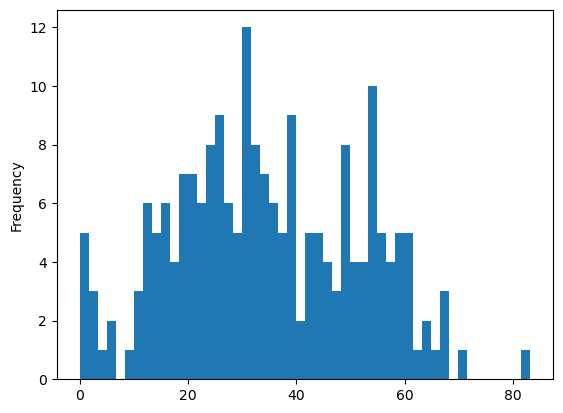

In [19]:
va2['No Vehicle Available'].plot.hist(bins=50)

Interesting! It seems like there is definitely a range with an average of around 40% of households without a car in DC.

## Converting vehicle ownership into a geodata frame
Now it's time to bring in vehicle tract data to be able to map it. First I will bring in the data. Next, I will join the census tracts to vehicle ownership data using GEOID.

In [20]:
tracts=gpd.read_file('data/Census_Tracts_in_2020.geojson')

Here's what the data looks like:

In [21]:
tracts.head()

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry
0,1,002002,11001002002,4072,3647,1116,1751,27,84,0,...,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948..."
1,2,002101,11001002101,5687,5071,1037,2642,86,120,1,...,0,0,0,31,0,0,31,0,0,"POLYGON ((-77.02824 38.95813, -77.02824 38.958..."
2,3,002102,11001002102,5099,4599,901,2910,50,87,0,...,0,0,0,145,0,0,145,0,0,"POLYGON ((-77.01997 38.95819, -77.01997 38.958..."
3,4,002201,11001002201,3485,3138,973,1722,21,94,2,...,6,0,0,0,0,0,0,0,0,"POLYGON ((-77.02743 38.95188, -77.02740 38.951..."
4,5,002202,11001002202,3339,2957,619,1636,48,57,3,...,0,0,0,4,0,0,4,0,0,"POLYGON ((-77.01968 38.95209, -77.01963 38.951..."


I want to see the breakdown of Census Tracts in DC and see what it looks like on a map:

<AxesSubplot: >

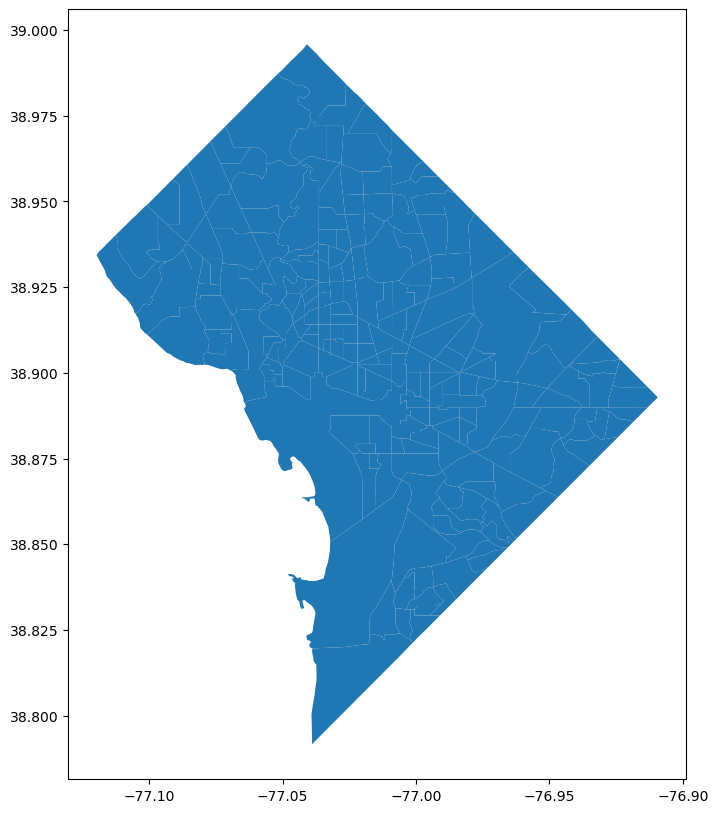

In [22]:
tracts.plot(figsize=(12,10))

Now let's see what type of data we are working with:

In [23]:
tracts.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 316 columns):
 #    Column     Non-Null Count  Dtype   
---   ------     --------------  -----   
 0    OBJECTID   206 non-null    int64   
 1    TRACT      206 non-null    object  
 2    GEOID      206 non-null    object  
 3    P0010001   206 non-null    int64   
 4    P0010002   206 non-null    int64   
 5    P0010003   206 non-null    int64   
 6    P0010004   206 non-null    int64   
 7    P0010005   206 non-null    int64   
 8    P0010006   206 non-null    int64   
 9    P0010007   206 non-null    int64   
 10   P0010008   206 non-null    int64   
 11   P0020002   206 non-null    int64   
 12   P0020005   206 non-null    int64   
 13   P0020006   206 non-null    int64   
 14   P0020007   206 non-null    int64   
 15   P0020008   206 non-null    int64   
 16   P0020009   206 non-null    int64   
 17   P0020010   206 non-null    int64   
 18   P0030001   206 non-null    int64   
 19 

Next, I will trim down the data to include only GEOID and geometry, which are the only two columns we will use.

In [24]:
tracts = tracts[['GEOID','geometry']]
tracts.head()

,GEOID,geometry
0,11001002002,"POLYGON ((-77.03642 38.94975, -77.03643 38.948..."
1,11001002101,"POLYGON ((-77.02824 38.95813, -77.02824 38.958..."
2,11001002102,"POLYGON ((-77.01997 38.95819, -77.01997 38.958..."
3,11001002201,"POLYGON ((-77.02743 38.95188, -77.02740 38.951..."
4,11001002202,"POLYGON ((-77.01968 38.95209, -77.01963 38.951..."


Next, I will merge the vehicle access data along GEOID.

In [25]:
tracts_vehicle=tracts.merge(va2,on="GEOID")

Let's double check that it worked:

In [26]:
tracts_vehicle.head()

,GEOID,geometry,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available
0,11001002002,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",12.02,50.00,27.09,6.91,1.00,2.99
1,11001002101,"POLYGON ((-77.02824 38.95813, -77.02824 38.958...",23.75,47.32,23.13,0.96,4.02,0.83
2,11001002102,"POLYGON ((-77.01997 38.95819, -77.01997 38.958...",23.18,44.99,31.16,0.66,0.00,0.00
3,11001002201,"POLYGON ((-77.02743 38.95188, -77.02740 38.951...",13.28,43.04,28.91,8.57,6.21,0.00
4,11001002202,"POLYGON ((-77.01968 38.95209, -77.01963 38.951...",23.20,44.73,12.80,19.27,0.00,0.00


Now that the data is merged, I want to add another column that combines together all the columns that indicate that a household has access to a vehicle.

In [27]:
vehicle_columns=['1 Vehicle Available',
'2 Vehicles Available',
'3 Vehicles Available',
'4 Vehicles Available',
'5 or More Vehicles Available']
tracts_vehicle['Any Vehicle'] = tracts_vehicle[vehicle_columns].sum(axis=1)

Let's make sure it worked:

In [28]:
# let's see if it worked
tracts_vehicle.head()

,GEOID,geometry,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available,Any Vehicle
0,11001002002,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",12.02,50.00,27.09,6.91,1.00,2.99,87.99
1,11001002101,"POLYGON ((-77.02824 38.95813, -77.02824 38.958...",23.75,47.32,23.13,0.96,4.02,0.83,76.26
2,11001002102,"POLYGON ((-77.01997 38.95819, -77.01997 38.958...",23.18,44.99,31.16,0.66,0.00,0.00,76.81
3,11001002201,"POLYGON ((-77.02743 38.95188, -77.02740 38.951...",13.28,43.04,28.91,8.57,6.21,0.00,86.73
4,11001002202,"POLYGON ((-77.01968 38.95209, -77.01963 38.951...",23.20,44.73,12.80,19.27,0.00,0.00,76.80


In [29]:
tracts_vehicle.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 206 entries, 0 to 205
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   GEOID                         206 non-null    object  
 1   geometry                      206 non-null    geometry
 2   No Vehicle Available          204 non-null    float64 
 3   1 Vehicle Available           204 non-null    float64 
 4   2 Vehicles Available          204 non-null    float64 
 5   3 Vehicles Available          204 non-null    float64 
 6   4 Vehicles Available          204 non-null    float64 
 7   5 or More Vehicles Available  204 non-null    float64 
 8   Any Vehicle                   206 non-null    float64 
dtypes: float64(7), geometry(1), object(1)
memory usage: 16.1+ KB


Looks good! Let's move onto mapping the data:

## Cleaning up the Ward Map

I'm bringing in a geojson of the DC ward map (2012) to overlay on top of the map. These boundaries remain in place for 10 years and were just recently redistricted. The dataset can be found here:

https://opendata.dc.gov/datasets/wards-from-2012/explore

In [30]:
wards=gpd.read_file('data/Wards_from_2012.geojson')

Let's make sure the ward information was brought in with all the information we need.

In [31]:
wards.head()

,OBJECTID,WARD,NAME,REP_NAME,WEB_URL,REP_PHONE,REP_EMAIL,REP_OFFICE,WARD_ID,LABEL,...,BACH_DEGREE_25_PLUS,MED_VAL_OOU,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,6,Ward 6,Charles Allen,https://www.dccouncil.us/council/councilmember...,(202) 724-8072,callen@dccouncil.us,"1350 Pennsylvania Ave, Suite 406, NW 20004",6,Ward 6,...,19588,573200,{5D2A5470-9BA3-4C94-9A21-46B5DBFF70D4},None,None,None,None,0,0,"POLYGON ((-77.01790 38.91410, -77.01801 38.914..."
1,2,8,Ward 8,"Trayon White, Sr.",https://www.dccouncil.us/council/councilmember...,(202) 724-8045,twhite@dccouncil.us,"1350 Pennsylvania Ave, Suite 400, NW 20004",8,Ward 8,...,3781,229900,{47803E60-D3B3-4445-A139-9456F9B20BED},None,None,None,None,0,0,"POLYGON ((-76.97229 38.87286, -76.97240 38.872..."
2,3,4,Ward 4,Janeese Lewis George,https://dccouncil.us/council/ward-4-councilmem...,(202) 724-8052,jlewisgeorge@dccouncil.us,"1350 Pennsylvania Ave, Suite 105, NW 20004",4,Ward 4,...,13032,491300,{C0E0D035-7F66-4819-887B-1575851278F3},None,None,None,None,0,0,"POLYGON ((-77.04097 38.99597, -77.07174 38.971..."
3,4,3,Ward 3,Mary M. Cheh,https://www.dccouncil.us/council/council-membe...,(202) 724-8062,mcheh@dccouncil.us,"1350 Pennsylvania Ave, Suite 108, NW 20004",3,Ward 3,...,19166,823800,{E6E33839-8446-458B-B7E9-BE071089193C},None,None,None,None,0,0,"POLYGON ((-77.05808 38.95676, -77.05809 38.956..."
4,5,5,Ward 5,Kenyan McDuffie,https://dccouncil.us/council/kenyan-mcduffie,(202) 724-8028,kmcduffie@dccouncil.us,"1350 Pennsylvania Ave, Suite 506, NW 20004",5,Ward 5,...,11557,379800,{7969341D-A3BD-4D6B-8257-F5DE354D001A},None,None,None,None,0,0,"POLYGON ((-76.99144 38.95730, -76.99163 38.957..."


There's a lot of cool information here but I think I'll only need 'WARD' and 'geometry' so I'll cut out the rest.

In [32]:
trim_columns=['WARD','NAME','geometry']
wards_trimmed = wards[trim_columns].copy()
wards_trimmed = wards_trimmed.dropna()
wards_trimmed.sample

<bound method NDFrame.sample of    WARD    NAME                                           geometry
0     6  Ward 6  POLYGON ((-77.01790 38.91410, -77.01801 38.914...
1     8  Ward 8  POLYGON ((-76.97229 38.87286, -76.97240 38.872...
2     4  Ward 4  POLYGON ((-77.04097 38.99597, -77.07174 38.971...
3     3  Ward 3  POLYGON ((-77.05808 38.95676, -77.05809 38.956...
4     5  Ward 5  POLYGON ((-76.99144 38.95730, -76.99163 38.957...
5     1  Ward 1  POLYGON ((-77.03523 38.93743, -77.03570 38.937...
6     2  Ward 2  POLYGON ((-77.04946 38.91999, -77.04973 38.920...
7     7  Ward 7  POLYGON ((-76.94186 38.91854, -76.94200 38.918...>

Now let's see what the ward boundaries look like...

<AxesSubplot: >

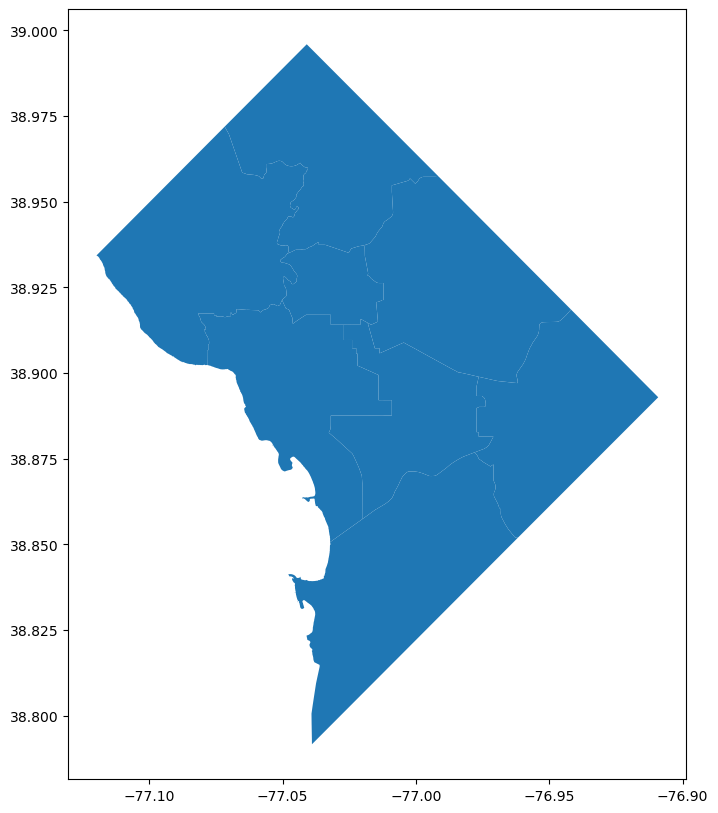

In [33]:
wards_trimmed.plot(figsize=(12,10))

Let's double check the projections to make sure we're all on the same page.

In [34]:
wards_trimmed.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since we'll be working with distances, I want to convert this into CRS 3857 

In [35]:
wards_trimmed = wards_trimmed.to_crs(epsg=3857)

In [36]:
wards_trimmed.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that we've done that, we can overlay the ward map on top of the vehicle access map.

## Mapping Vehicle Access by Ward

Bringing everything together now.

First, I want to check the projection of the vehicle access data and keep it in 3857

In [37]:
tracts_vehicle.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's convert it to EPSG 3857 because the projection will be cleaner for the map.

In [38]:
tracts_vehicle_new = tracts_vehicle.to_crs(epsg=3857)

Now, I want to create a map that displays the percentage of households that do not have access to a vehicle. I will then plot ward boundaries on top of that to consistently display the same ward context across maps.

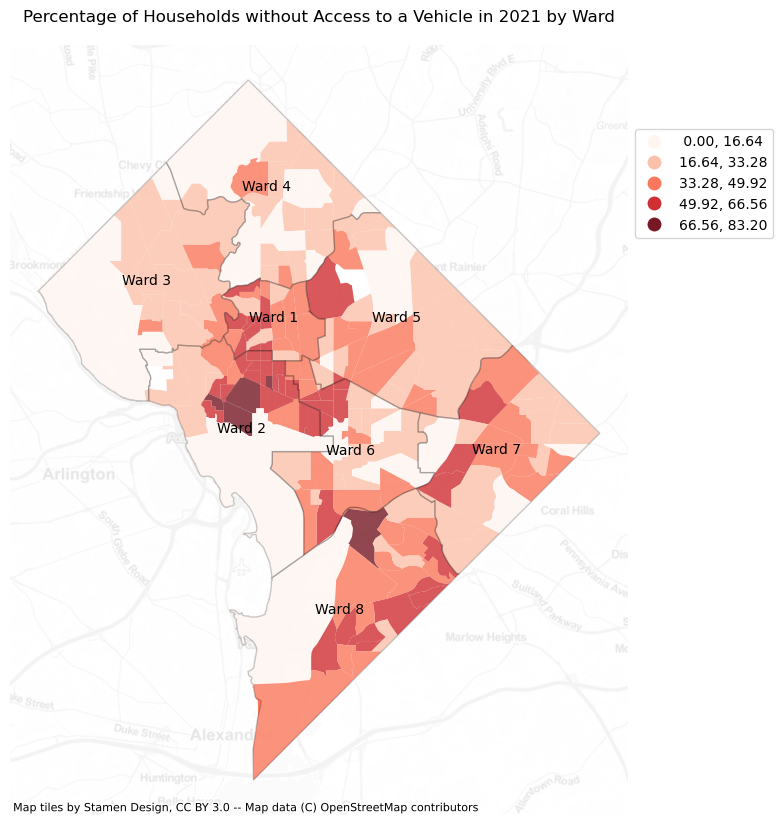

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

tracts_vehicle_new.plot(figsize=(12,10),
                        column='No Vehicle Available',
                        legend=True,
                        cmap='Reds',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=0.9)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   alpha=0.2)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Percentage of Households without Access to a Vehicle in 2021 by Ward')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )

Let's adjust this to make the ward boundaries a little stronger. I'll change the line width and adjust the transparency a little.

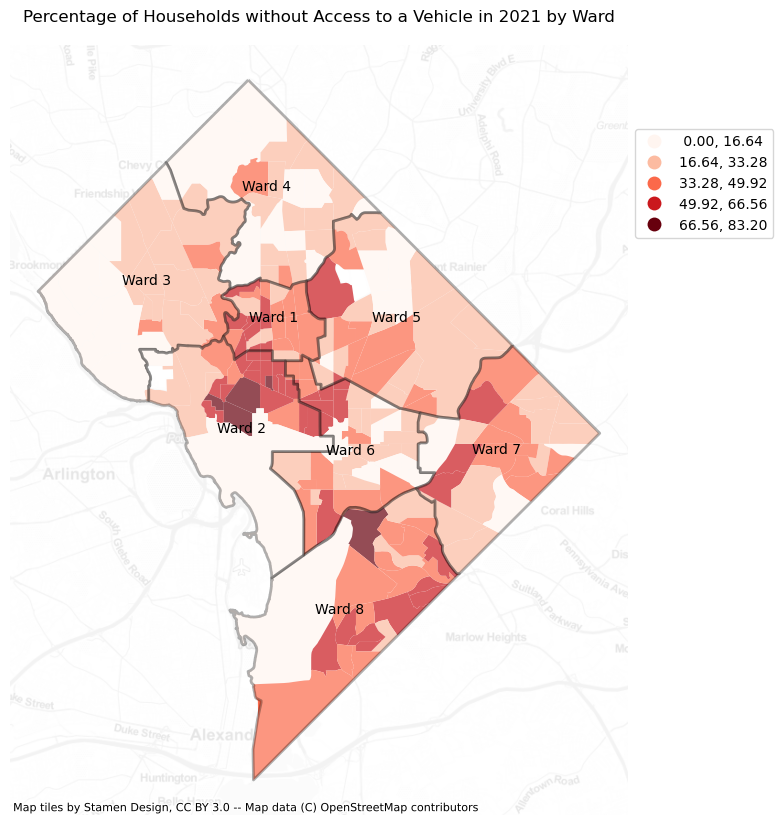

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

tracts_vehicle_new.plot(figsize=(12,10),
                        column='No Vehicle Available',
                        legend=True,
                        cmap='Reds',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=1)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   linewidth=2,
                   alpha=0.3)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Percentage of Households without Access to a Vehicle in 2021 by Ward')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )

## Merging Vehicle Access with Low Food Access Areas

Pulling from Open Data DC, they have created a geojson that defines low food access areas as anywhere that is more than a 10 minute walk to the nearest Grocery Store in 2018. The dataset also joined income information to create columns related to the percentage of the households in these areas that have income below 185% of the Federal Poverty Level (FPL).

The dataset can be found here:  https://opendata.dc.gov/datasets/DCGIS::low-food-access-areas/explore?location=38.890907%2C-77.026467%2C12.77

Given this dataset, I want to create a new map that shows the overlap between areas with higher percentages of households without a car and these low food access areas. Then, I will refine these maps further to account for income.

In [41]:
access=gpd.read_file('data/Low_Food_Access_Areas.geojson')

Let's see what information it contains!

In [42]:
access.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       381 non-null    int64   
 1   FID_GROCER     381 non-null    int64   
 2   FID_GROC_1     381 non-null    int64   
 3   FACILITYID     381 non-null    int64   
 4   FID_POV_AC     381 non-null    int64   
 5   GEOID          381 non-null    object  
 6   FIRST_TOTA     381 non-null    int64   
 7   FIRST_UNDE     381 non-null    int64   
 8   FIRST_OVER     381 non-null    int64   
 9   POPAREA        381 non-null    float64 
 10  SHAPE_LENG     381 non-null    float64 
 11  PARTPOP        381 non-null    int64   
 12  PARTUNDER1     381 non-null    int64   
 13  PARTOVER18     381 non-null    int64   
 14  PARTAREA       381 non-null    float64 
 15  AREARATIO      381 non-null    float64 
 16  GROCERYACC     381 non-null    object  
 17  FID_WARDPL     381 non-null

In [43]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [44]:
access.head()

,OBJECTID,FID_GROCER,FID_GROC_1,FACILITYID,FID_POV_AC,GEOID,FIRST_TOTA,FIRST_UNDE,FIRST_OVER,POPAREA,SHAPE_LENG,PARTPOP,PARTUNDER1,PARTOVER18,PARTAREA,AREARATIO,GROCERYACC,FID_WARDPL,WARD,NAME,SHAPE_LE_1,SHAPE_AR_1,WRDPRTAREA,AREARTIO2,PARTPOP2,PRTOVR185,PRTUND185,PERCENTUND185,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,77,-1,0,78,110010016004,1682,86,1596,875665.647356,8862.458495,1405,72,1333,731490.545391,0.835354,N,8,4,Ward 4,25130.994398,2.331492e+07,731492.0,1.0,1405,1333,72,0.051246,LowFoodAccessPly_36,{FF96FCBB-7D7E-4898-913E-5F212838668D},None,None,None,None,0,0,"MULTIPOLYGON (((-77.03633 38.99073, -77.03639 ..."
1,2,74,-1,0,75,110010016001,1191,71,1120,451499.442030,3878.614656,1191,71,1120,451499.452113,1.000000,N,8,4,Ward 4,25130.994398,2.331492e+07,451499.0,1.0,1191,1120,71,0.059614,LowFoodAccessPly_37,{B0964E8D-C59E-47E7-BBF1-B997B15ACD31},None,None,None,None,0,0,"POLYGON ((-77.02660 38.98452, -77.02687 38.984..."
2,3,69,-1,0,70,110010015001,1654,51,1603,834116.766326,7692.482644,1654,51,1603,834116.692261,1.000000,N,8,4,Ward 4,25130.994398,2.331492e+07,834115.0,1.0,1654,1603,51,0.030834,LowFoodAccessPly_38,{7C2582DE-0DBF-4496-9D85-C9EDF2EA8DFA},None,None,None,None,0,0,"MULTIPOLYGON (((-77.05260 38.96164, -77.05265 ..."
3,4,354,-1,0,428,110010103002,1312,455,857,240320.505856,2699.965876,1312,455,857,240320.503427,1.000000,N,8,4,Ward 4,25130.994398,2.331492e+07,239769.0,1.0,1312,857,455,0.346799,LowFoodAccessPly_39,{D5861A4D-9AAA-443F-A5EC-A099A62987C3},None,None,None,None,0,0,"POLYGON ((-77.02227 38.98138, -77.02239 38.981..."
4,5,75,-1,0,76,110010016002,606,62,544,192218.254228,2372.363010,606,62,544,192218.256000,1.000000,N,8,4,Ward 4,25130.994398,2.331492e+07,192218.0,1.0,606,544,62,0.102310,LowFoodAccessPly_40,{95062827-C1F9-4AC5-9DC3-8EE71FD0CBA4},None,None,None,None,0,0,"POLYGON ((-77.02643 38.97831, -77.02643 38.978..."


Now, I want to clean up the information so only the relevant columns are left. Though I will mainly focus on 'PERCENTUND185', I will still keep this other information available in case it's useful later.

In [45]:
access = access[['WARD','PARTPOP2','PRTOVR185','PRTUND185','PERCENTUND185','GLOBALID','geometry']]

Now, I'll go ahead and rename everything so that it's more readable:

In [46]:
access.rename(columns={'PARTPOP2':'Total Population',
                       'PRTOVR185':'Income Above FPL',
                       'PRTUND185':'Income Below FPL',
                       'PERCENTUND185':'Percent Food Insecure'                       
                      }, inplace=True)
access.tail(1)

,WARD,Total Population,Income Above FPL,Income Below FPL,Percent Food Insecure,GLOBALID,geometry
380,8,2171,947,1224,0.563796,{21149F00-A38D-46D3-8445-43F16481CDE7},"POLYGON ((-77.01156 38.82283, -77.01155 38.822..."


I'll come back to the Percent Food Insecure later. This will be the final part of the access mapping that I will do.

In the meantime, let's double check the coordinate system to make sure it's in EPSG: 3857

In [47]:
access.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Switch it over to 3857

In [48]:
access = access.to_crs(epsg=3857)

We can see that the Geometry is a combination of polygons. Let's go ahead and map those using MapPlotLib

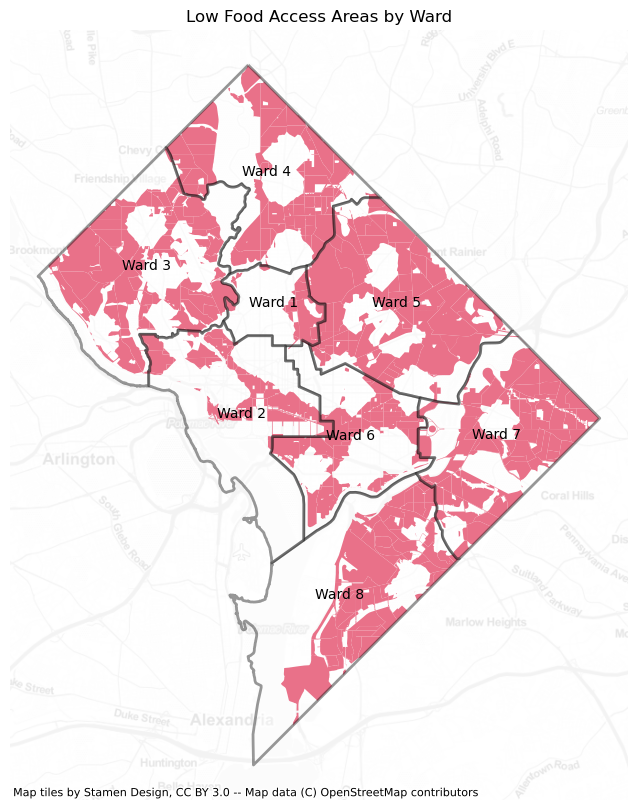

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

access.plot(figsize=(12,10),
                        legend=True,
                        color='crimson',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=1.0)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   linewidth=2,
                   alpha=0.4)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Low Food Access Areas by Ward')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )

## Overlaying Vehicle Access with Low Food Access Areas

Since the geometries for vehicle access and low food access are different (i.e. census tract vs various polygons), I believe the best thing to do is overlay vehicle access maps with low food access areas. To do this, I will first create a variable that shows only the tracts with 50% or more households without access to a vehicle. Then I will do an overlay (using the intersection predicate) to show where these geometries overlap.

In [50]:
vehicle_50=tracts_vehicle_new[(tracts_vehicle_new['No Vehicle Available']>49.99)]

I think it worked! Let's see how many tracts have 50% or higher of households without vehicle access.

In [51]:
vehicle_50.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 46 entries, 42 to 200
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   GEOID                         46 non-null     object  
 1   geometry                      46 non-null     geometry
 2   No Vehicle Available          46 non-null     float64 
 3   1 Vehicle Available           46 non-null     float64 
 4   2 Vehicles Available          46 non-null     float64 
 5   3 Vehicles Available          46 non-null     float64 
 6   4 Vehicles Available          46 non-null     float64 
 7   5 or More Vehicles Available  46 non-null     float64 
 8   Any Vehicle                   46 non-null     float64 
dtypes: float64(7), geometry(1), object(1)
memory usage: 3.6+ KB


Let's map it to see if it corresponds with our map above.

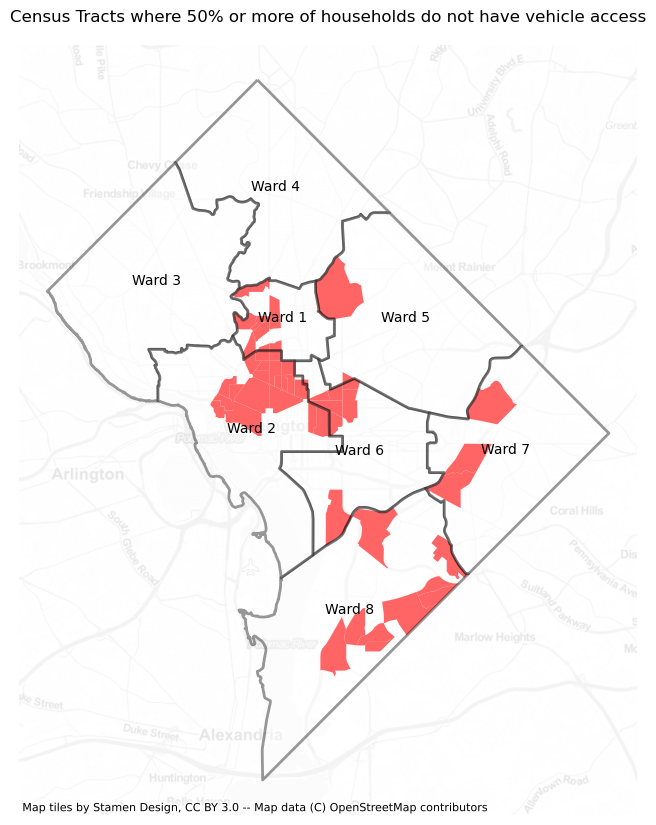

In [52]:
fig, ax = plt.subplots(figsize=(10,10))

vehicle_50.plot(figsize=(12,10),
                        legend=True,
                        color='red',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=1.0)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   linewidth=2,
                   alpha=0.4)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Census Tracts where 50% or more of households do not have vehicle access')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )

Very happy with this map! Now, let's do the overlay to see which of these tracts are more than 10 minutes away walking from a grocery store.

In [53]:
access_overlay=vehicle_50.overlay(access,how='intersection',keep_geom_type=False)

Now to check to see if it worked?

In [54]:
access_overlay.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   GEOID                         149 non-null    object  
 1   No Vehicle Available          149 non-null    float64 
 2   1 Vehicle Available           149 non-null    float64 
 3   2 Vehicles Available          149 non-null    float64 
 4   3 Vehicles Available          149 non-null    float64 
 5   4 Vehicles Available          149 non-null    float64 
 6   5 or More Vehicles Available  149 non-null    float64 
 7   Any Vehicle                   149 non-null    float64 
 8   WARD                          149 non-null    int64   
 9   Total Population              149 non-null    int64   
 10  Income Above FPL              149 non-null    int64   
 11  Income Below FPL              149 non-null    int64   
 12  Percent Food Insecure         149 non-null

It seems that there are new geometries created, which makes sense because it will not be in the same geometry as the census tracts. I want to see what happens when I map it.

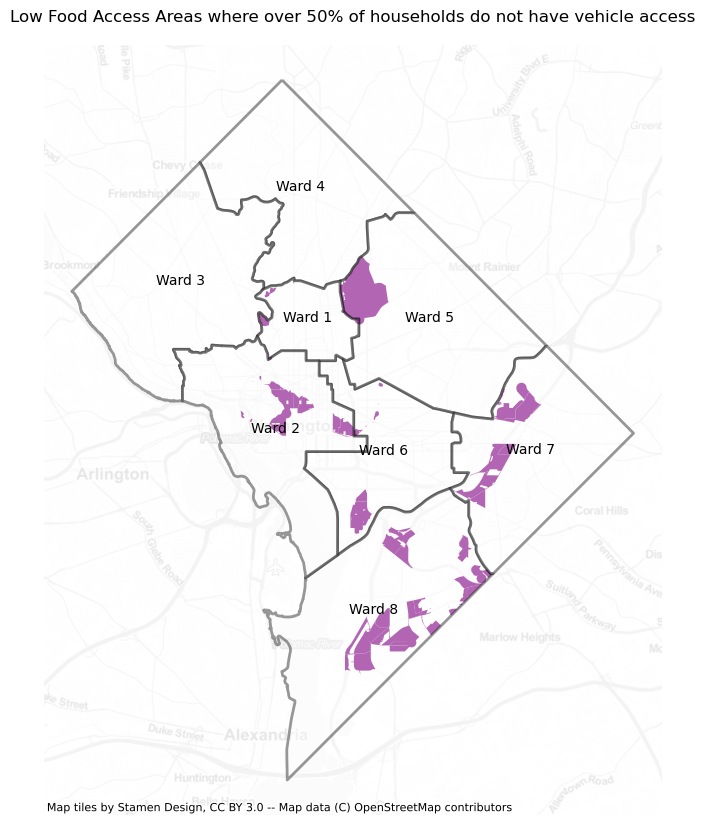

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

access_overlay.plot(figsize=(12,10),
                        legend=True,
                        color='purple',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=1.0)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   linewidth=2,
                   alpha=0.4)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Low Food Access Areas where over 50% of households do not have vehicle access')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )

## Overlaying Vehicle Access, Low Food Access, and Percentage of Low Income Households

Now, the last variable that we want to combine into this narrative is poverty. The 2018 dataset defines low-income households in DC as those living below 185% of the Federal Poverty Line. Let's identify tracts where 20% or more of households earn below this threshold:

In [56]:
access['Percentage below 185% FPL']=access['Percent Food Insecure']*100

In [57]:
low_20=access[(access['Percentage below 185% FPL']>19.99)]

In [58]:
low_20.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 217 entries, 3 to 380
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   WARD                       217 non-null    int64   
 1   Total Population           217 non-null    int64   
 2   Income Above FPL           217 non-null    int64   
 3   Income Below FPL           217 non-null    int64   
 4   Percent Food Insecure      217 non-null    float64 
 5   GLOBALID                   217 non-null    object  
 6   geometry                   217 non-null    geometry
 7   Percentage below 185% FPL  217 non-null    float64 
dtypes: float64(2), geometry(1), int64(4), object(1)
memory usage: 15.3+ KB


Let's plot these low food access areas with at least 20% of households living below 185% of the Federal Poverty Line.

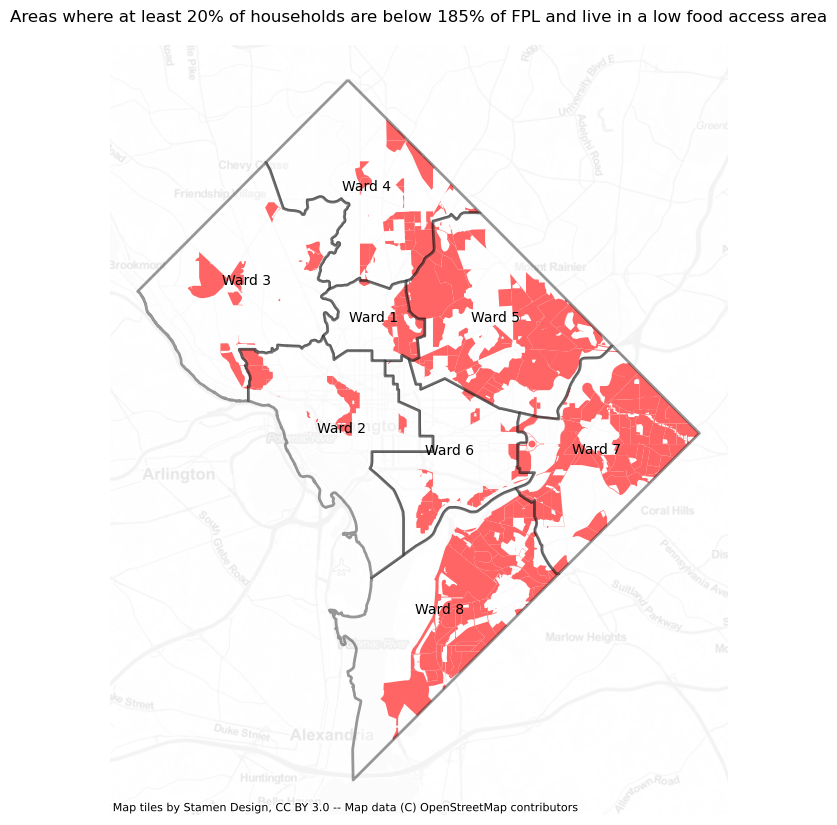

In [59]:
fig, ax = plt.subplots(figsize=(10,10))

low_20.plot(figsize=(12,10),
                        legend=True,
                        color='red',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=1.0)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   linewidth=2,
                   alpha=0.4)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Areas where at least 20% of households are below 185% of FPL and live in a low food access area')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1 # add transparency to make it less dominant
                )

Now, I want to see what it looks like to just map low food access areas based on percentage of households below 185% of the Federal Poverty Line. I will do a map with minimal labeling and context mapping because I feel like the previous maps have provided that.

Text(0.5, 1.0, 'Low Food Access Areas and Percentage of Households Living below 185% of FPL')

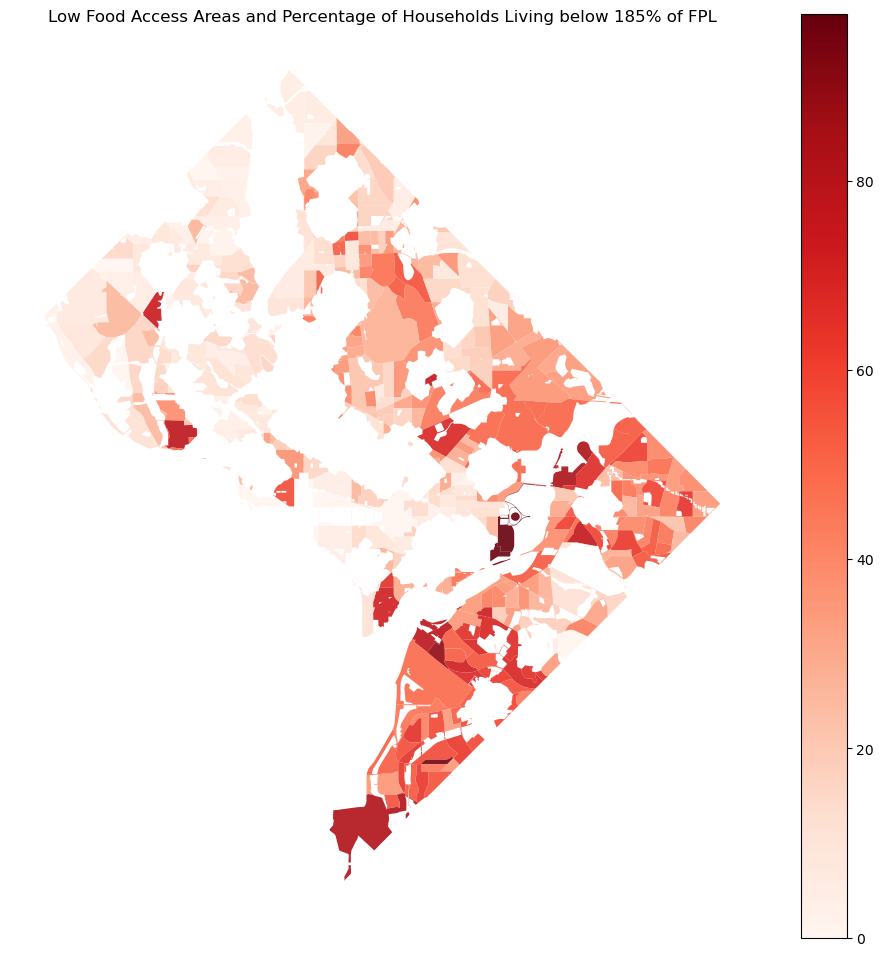

In [60]:
fig,ax = plt.subplots(figsize=(12,12))

access.plot(ax=ax,column='Percentage below 185% FPL',
            legend=True,
            alpha=0.9,
            cmap='Reds')

ax.axis('off')

ax.set_title('Low Food Access Areas and Percentage of Households Living below 185% of FPL')

This is a very powerful map to me! There's something about seeing poverty reflected at the more granular level that is really striking. You can also see the pockets of white in the middle of DC where you have high levels of food access.

Time to overlay everything together: vehicle access, low food access, and areas where at least 20% of households are living below 185% of the FPL.

In [61]:
total_overlay=vehicle_50.overlay(low_20,how='intersection',keep_geom_type=False)

Let's map this overlay, which will show where 50% of households do not have access to a vehicle, 20% of households live below 185% of the Federal Poverty Level, and residents are more than a 10 minute walk to the nearest grocery store.

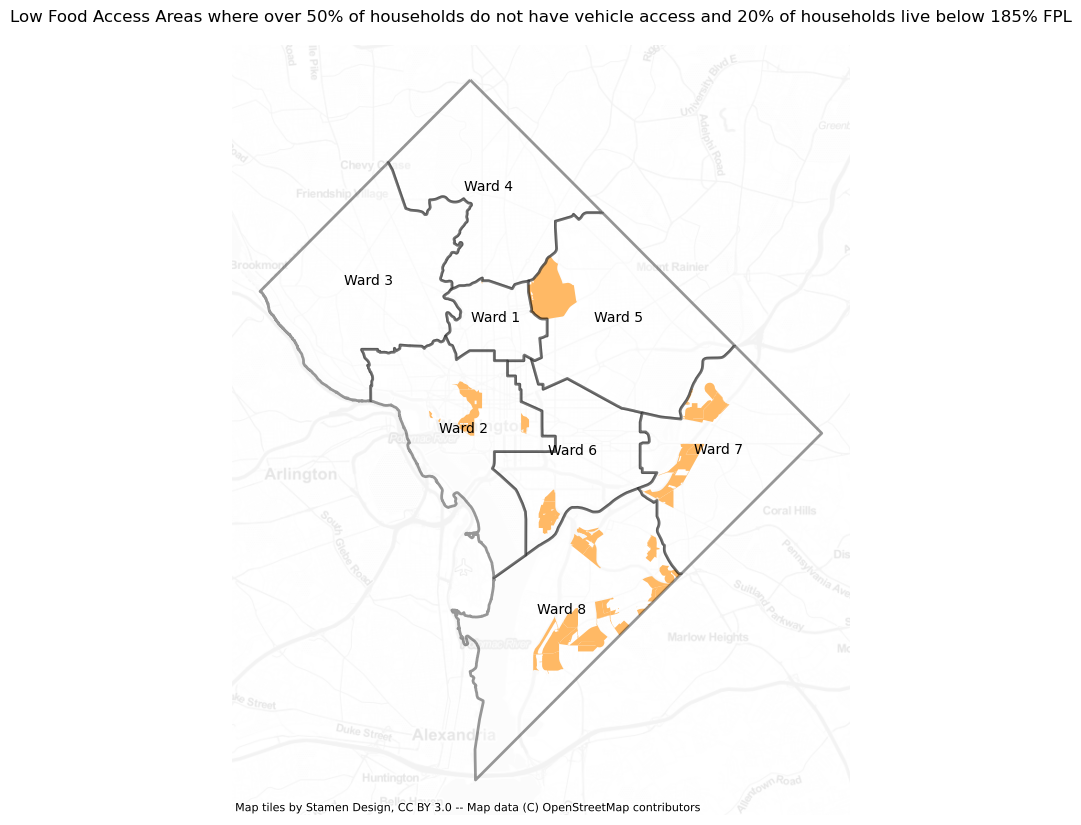

In [62]:
fig, ax = plt.subplots(figsize=(10,10))

total_overlay.plot(figsize=(12,10),
                        legend=True,
                        color='darkorange',
                        ax=ax,
                        legend_kwds={'loc':'upper left','bbox_to_anchor':(1,.9)},
                        scheme='equal_interval', alpha=1.0)

wards_trimmed.plot(ax=ax,
                   color='white', 
                   edgecolor='black',
                   linewidth=2,
                   alpha=0.4)

wards_trimmed.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

ax.axis('off')

ax.set_title('Low Food Access Areas where over 50% of households do not have vehicle access and 20% of households live below 185% FPL')

ctx.add_basemap(ax=ax,
                crs=3857,
                source=ctx.providers.Stamen.TonerLite,
                alpha=0.1)

## Pulling Access Centroids to Produce Isochrone Maps

Now that we have this information about areas with low vehicle access and low food access, I want to calculate the centroids for a sample (one from each ward). I will then make an isochrone map for each point. It would obviously be impossible to make isochrone maps for all 149 polygons that have low food access.

Let's begin by getting a sample of the access_overlay dataframe.

In [63]:
total_overlay.sample(10)

,GEOID,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available,Any Vehicle,WARD,Total Population,Income Above FPL,Income Below FPL,Percent Food Insecure,GLOBALID,Percentage below 185% FPL,geometry
19,11001005501,54.02,31.37,14.62,0.00,0.00,0.00,45.99,2,30,22,8,0.266667,{07B33D3E-9EB4-4E77-8515-6C6B77EB6E56},26.666668,"POLYGON ((-8576695.917 4708381.863, -8576720.4..."
94,11001009802,61.00,22.00,14.03,1.55,1.43,0.00,39.01,8,1762,644,1118,0.634506,{6B17C4FD-A4E7-4EEB-95E4-FE855378B647},63.450623,"MULTIPOLYGON (((-8571453.489 4697237.266, -857..."
18,11001010700,70.44,27.31,2.25,0.00,0.00,0.00,29.56,2,369,274,96,0.260163,{A5619B15-D7A4-4620-B1B1-10DA913067F3},26.016259,"MULTIPOLYGON (((-8576601.741 4708511.900, -857..."
38,11001007304,54.02,38.61,6.90,0.47,0.00,0.00,45.98,8,296,194,102,0.344595,{7ED94F1F-25CD-4845-BF3E-FDB6822246D0},34.459460,"POLYGON ((-8570958.244 4699306.698, -8570958.2..."
80,11001007709,54.60,34.94,6.92,1.86,1.69,0.00,45.41,7,1006,729,277,0.275348,{6A3FC7C5-9243-4082-BE47-88B9C33BC208},27.534792,"MULTIPOLYGON (((-8567679.481 4703223.790, -856..."
22,11001005602,50.25,45.69,4.06,0.00,0.00,0.00,49.75,2,81,58,24,0.296296,{C87F2AF9-C81E-4B88-9C78-EC78FC9A4DDB},29.629630,"POLYGON ((-8577484.393 4706828.559, -8577488.6..."
20,11001010700,70.44,27.31,2.25,0.00,0.00,0.00,29.56,2,30,22,8,0.266667,{07B33D3E-9EB4-4E77-8515-6C6B77EB6E56},26.666668,"POLYGON ((-8576695.917 4708381.863, -8576686.5..."
23,11001005801,55.16,44.84,0.00,0.00,0.00,0.00,44.84,2,929,682,247,0.265877,{EAD03488-1F5B-441E-953A-36F58F0948B5},26.587728,"POLYGON ((-8573905.916 4706355.420, -8573910.8..."
107,11001009807,53.37,22.23,17.77,3.72,0.43,2.48,46.63,8,2056,363,1693,0.823444,{D2C833C8-CDEA-441B-A488-F2FE90EEEE44},82.344359,"MULTIPOLYGON (((-8572271.968 4696505.174, -857..."
112,11001010700,70.44,27.31,2.25,0.00,0.00,0.00,29.56,2,318,254,64,0.201258,{05861214-6F81-4CB6-8C38-765676A728D8},20.125785,"POLYGON ((-8576597.355 4708517.996, -8576490.7..."


Now I want to create a list of polygons of these low access areas within wards 2, 7, and 8 so I can calculate centroids.

In [64]:
ward2_list=total_overlay[total_overlay['WARD']==2]
ward7_list=total_overlay[total_overlay['WARD']==7]
ward8_list=total_overlay[total_overlay['WARD']==8]

Let's see these lists:

In [65]:
ward2_list.sample(10)

,GEOID,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available,Any Vehicle,WARD,Total Population,Income Above FPL,Income Below FPL,Percent Food Insecure,GLOBALID,Percentage below 185% FPL,geometry
17,11001005501,54.02,31.37,14.62,0.0,0.0,0.00,45.99,2,369,274,96,0.260163,{A5619B15-D7A4-4620-B1B1-10DA913067F3},26.016259,"POLYGON ((-8576760.594 4708394.738, -8576686.5..."
22,11001005602,50.25,45.69,4.06,0.0,0.0,0.00,49.75,2,81,58,24,0.296296,{C87F2AF9-C81E-4B88-9C78-EC78FC9A4DDB},29.629630,"POLYGON ((-8577484.393 4706828.559, -8577488.6..."
20,11001010700,70.44,27.31,2.25,0.0,0.0,0.00,29.56,2,30,22,8,0.266667,{07B33D3E-9EB4-4E77-8515-6C6B77EB6E56},26.666668,"POLYGON ((-8576695.917 4708381.863, -8576686.5..."
19,11001005501,54.02,31.37,14.62,0.0,0.0,0.00,45.99,2,30,22,8,0.266667,{07B33D3E-9EB4-4E77-8515-6C6B77EB6E56},26.666668,"POLYGON ((-8576695.917 4708381.863, -8576720.4..."
110,11001010700,70.44,27.31,2.25,0.0,0.0,0.00,29.56,2,368,229,139,0.377717,{C20D7E20-E0B8-4B99-9EA5-9FA7E08B19FA},37.771741,"POLYGON ((-8575970.559 4707178.851, -8575983.1..."
23,11001005801,55.16,44.84,0.00,0.0,0.0,0.00,44.84,2,929,682,247,0.265877,{EAD03488-1F5B-441E-953A-36F58F0948B5},26.587728,"POLYGON ((-8573905.916 4706355.420, -8573910.8..."
21,11001005602,50.25,45.69,4.06,0.0,0.0,0.00,49.75,2,116,86,30,0.258621,{FF376C82-B339-4820-8296-B721B45CCD07},25.862068,"MULTIPOLYGON (((-8577666.725 4706980.418, -857..."
111,11001010800,83.20,14.06,1.82,0.0,0.0,0.91,16.79,2,368,229,139,0.377717,{C20D7E20-E0B8-4B99-9EA5-9FA7E08B19FA},37.771741,POINT (-8576016.534 4707199.305)
18,11001010700,70.44,27.31,2.25,0.0,0.0,0.00,29.56,2,369,274,96,0.260163,{A5619B15-D7A4-4620-B1B1-10DA913067F3},26.016259,"MULTIPOLYGON (((-8576601.741 4708511.900, -857..."
16,11001005503,60.90,39.10,0.00,0.0,0.0,0.00,39.10,2,798,524,274,0.343358,{33D3A4A6-FBC7-4F63-A923-9675F3B13AD3},34.335840,"POLYGON ((-8577033.104 4708583.857, -8577033.1..."


In [66]:
ward7_list.sample(10)

,GEOID,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available,Any Vehicle,WARD,Total Population,Income Above FPL,Income Below FPL,Percent Food Insecure,GLOBALID,Percentage below 185% FPL,geometry
75,11001007709,54.60,34.94,6.92,1.86,1.69,0.00,45.41,7,1250,582,668,0.534400,{1DCDD257-E582-42E1-A59E-0580954B1EA2},53.439999,"MULTIPOLYGON (((-8568409.960 4703627.292, -856..."
83,11001009602,54.71,31.13,10.15,2.64,1.18,0.18,45.28,7,1477,481,996,0.674340,{2A3D9C63-A7E1-416D-84ED-041C19C45510},67.433989,"MULTIPOLYGON (((-8565383.944 4707569.399, -856..."
79,11001007709,54.60,34.94,6.92,1.86,1.69,0.00,45.41,7,1378,845,533,0.386792,{4E9C542E-4C07-4057-935E-40E96C214820},38.679245,"MULTIPOLYGON (((-8568022.051 4703402.681, -856..."
80,11001007709,54.60,34.94,6.92,1.86,1.69,0.00,45.41,7,1006,729,277,0.275348,{6A3FC7C5-9243-4082-BE47-88B9C33BC208},27.534792,"MULTIPOLYGON (((-8567679.481 4703223.790, -856..."
73,11001007708,58.65,35.15,6.20,0.00,0.00,0.00,41.35,7,517,260,257,0.497099,{B9525521-AC01-415B-B34C-2DC4FE4D915A},49.709865,"MULTIPOLYGON (((-8566457.415 4705753.159, -856..."
71,11001007709,54.60,34.94,6.92,1.86,1.69,0.00,45.41,7,1470,897,573,0.389796,{0F3BE37B-A29F-4F2D-898F-968A3BEB7D81},38.979593,"MULTIPOLYGON (((-8567027.997 4704741.284, -856..."
85,11001009602,54.71,31.13,10.15,2.64,1.18,0.18,45.28,7,855,669,186,0.217544,{38A429A5-A675-4886-B61D-D83EF2504F34},21.754386,"POLYGON ((-8566515.603 4706797.496, -8566477.0..."
67,11001007502,54.73,34.71,6.44,4.13,0.00,0.00,45.28,7,623,405,218,0.349920,{CB5C6F13-8EF8-435E-864D-F5D71880B5B7},34.991974,"MULTIPOLYGON (((-8567367.007 4700484.495, -856..."
74,11001007708,58.65,35.15,6.20,0.00,0.00,0.00,41.35,7,1250,582,668,0.534400,{1DCDD257-E582-42E1-A59E-0580954B1EA2},53.439999,"MULTIPOLYGON (((-8567022.807 4704742.222, -856..."
68,11001007708,58.65,35.15,6.20,0.00,0.00,0.00,41.35,7,1136,781,355,0.312500,{2BB1E96A-D2A4-4489-8616-14054A5F4C64},31.250000,"POLYGON ((-8567285.521 4705907.332, -8567126.4..."


In [67]:
ward8_list.sample(10)

,GEOID,No Vehicle Available,1 Vehicle Available,2 Vehicles Available,3 Vehicles Available,4 Vehicles Available,5 or More Vehicles Available,Any Vehicle,WARD,Total Population,Income Above FPL,Income Below FPL,Percent Food Insecure,GLOBALID,Percentage below 185% FPL,geometry
93,11001009801,59.20,33.89,6.90,0.00,0.00,0.00,40.79,8,1762,644,1118,0.634506,{6B17C4FD-A4E7-4EEB-95E4-FE855378B647},63.450623,"POLYGON ((-8571677.855 4697487.997, -8571697.0..."
50,11001007401,67.36,29.83,2.81,0.00,0.00,0.00,32.64,8,1095,115,980,0.894977,{E54F63A8-F910-4E19-83E9-A2A1598468B9},89.497715,"POLYGON ((-8571167.010 4701044.560, -8571422.1..."
46,11001009803,51.44,35.23,5.63,5.02,1.54,1.14,48.56,8,2099,885,1214,0.578371,{E8933B2B-7609-4151-A98D-A709A66FB643},57.837063,"MULTIPOLYGON (((-8571664.608 4697924.225, -857..."
36,11001007409,55.44,33.67,9.02,0.00,0.37,1.49,44.55,8,803,336,467,0.581569,{33AF91AC-C396-4AE7-A482-E557B12D72EE},58.156914,"MULTIPOLYGON (((-8568642.883 4699241.155, -856..."
49,11001007401,67.36,29.83,2.81,0.00,0.00,0.00,32.64,8,1851,873,978,0.528363,{ED5A30A2-60CF-4BAA-90C8-2A51C0E168D9},52.836305,"MULTIPOLYGON (((-8570655.720 4702090.583, -857..."
54,11001007502,54.73,34.71,6.44,4.13,0.00,0.00,45.28,8,2774,845,1929,0.695386,{B131C41A-7AE5-4916-B2C8-4208640C480B},69.538575,GEOMETRYCOLLECTION (POLYGON ((-8568799.689 470...
103,11001009803,51.44,35.23,5.63,5.02,1.54,1.14,48.56,8,821,286,535,0.651644,{1A826F3A-F5C9-4377-B637-EABEEED24931},65.164435,"POLYGON ((-8572407.443 4697543.729, -8572455.6..."
96,11001009802,61.00,22.00,14.03,1.55,1.43,0.00,39.01,8,3167,1387,1780,0.562046,{6E5EA4BC-3F69-470F-BD03-CC94530EB05C},56.204611,"MULTIPOLYGON (((-8571108.567 4697236.781, -857..."
99,11001009803,51.44,35.23,5.63,5.02,1.54,1.14,48.56,8,827,392,435,0.525998,{CC4F7C1B-7048-4A6C-956B-7DB0B5F37C89},52.599758,"MULTIPOLYGON (((-8572466.554 4698155.222, -857..."
56,11001007403,61.24,28.69,9.46,0.00,0.61,0.00,38.76,8,1655,720,935,0.564955,{A1FB561D-E18F-4689-9659-DB4445ACA208},56.495470,"POLYGON ((-8568512.151 4699873.289, -8568522.6..."


I want to get rid of everything so I only see the 'geometry' columns, which will make it easier visually to work with for the purposes of calculating centroids.

In [68]:
new_columns=['GLOBALID','geometry']

In [69]:
ward2_trimmed=ward2_list[new_columns]
ward7_trimmed=ward7_list[new_columns]
ward8_trimmed=ward8_list[new_columns]

Let's see the new lists:

In [70]:
ward2_trimmed.sample(5)

,GLOBALID,geometry
16,{33D3A4A6-FBC7-4F63-A923-9675F3B13AD3},"POLYGON ((-8577033.104 4708583.857, -8577033.1..."
110,{C20D7E20-E0B8-4B99-9EA5-9FA7E08B19FA},"POLYGON ((-8575970.559 4707178.851, -8575983.1..."
18,{A5619B15-D7A4-4620-B1B1-10DA913067F3},"MULTIPOLYGON (((-8576601.741 4708511.900, -857..."
112,{05861214-6F81-4CB6-8C38-765676A728D8},"POLYGON ((-8576597.355 4708517.996, -8576490.7..."
113,{491956A5-050F-47F6-8B69-C02131D33FE0},"MULTIPOLYGON (((-8576081.322 4707228.485, -857..."


In [71]:
ward7_trimmed.sample(5)

,GLOBALID,geometry
67,{CB5C6F13-8EF8-435E-864D-F5D71880B5B7},"MULTIPOLYGON (((-8567367.007 4700484.495, -856..."
74,{1DCDD257-E582-42E1-A59E-0580954B1EA2},"MULTIPOLYGON (((-8567022.807 4704742.222, -856..."
71,{0F3BE37B-A29F-4F2D-898F-968A3BEB7D81},"MULTIPOLYGON (((-8567027.997 4704741.284, -856..."
82,{2590DAE3-7BFF-4A6A-9725-2CB96A4C6035},"MULTIPOLYGON (((-8566868.741 4706868.895, -856..."
75,{1DCDD257-E582-42E1-A59E-0580954B1EA2},"MULTIPOLYGON (((-8568409.960 4703627.292, -856..."


In [72]:
ward8_trimmed.sample(5)

,GLOBALID,geometry
87,{41E47858-949D-4C74-BF0C-2960188CFAAB},"POLYGON ((-8570693.012 4697692.062, -8570681.1..."
36,{33AF91AC-C396-4AE7-A482-E557B12D72EE},"MULTIPOLYGON (((-8568642.883 4699241.155, -856..."
91,{A81EDF92-C73D-4A25-B74A-27EA270B75CA},"POLYGON ((-8571664.608 4697487.997, -8571664.6..."
100,{CC4F7C1B-7048-4A6C-956B-7DB0B5F37C89},"POLYGON ((-8572455.422 4697381.537, -8572455.3..."
101,{6BC8501E-0EBC-461C-99D2-3F5172D9AF00},"POLYGON ((-8572516.425 4697692.061, -8572520.8..."


Now I want to go ahead and find the centroid of all the points in each ward using the .centroid function.

In [73]:
centroids_2=ward2_trimmed['geometry'].centroid

In [74]:
centroids_7=ward7_trimmed['geometry'].centroid

In [75]:
centroids_8=ward8_trimmed['geometry'].centroid

Maybe I can convert this information back into CRS:4326 which will give me latitude and longitude...let's try it

In [76]:
centroids_2.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [77]:
centroids_2 = centroids_2.to_crs(epsg=4326)

In [78]:
print(centroids_2)

15     POINT (-77.04713 38.90725)
16     POINT (-77.04880 38.90862)
17     POINT (-77.04616 38.90725)
18     POINT (-77.04530 38.90766)
19     POINT (-77.04652 38.90716)
20     POINT (-77.04586 38.90707)
21     POINT (-77.05583 38.89834)
22     POINT (-77.05253 38.89667)
23     POINT (-77.02060 38.89575)
24     POINT (-77.01915 38.89555)
109    POINT (-77.03655 38.90197)
110    POINT (-77.03988 38.90297)
111    POINT (-77.03967 38.89889)
112    POINT (-77.04354 38.90661)
113    POINT (-77.04002 38.89902)
114    POINT (-77.04182 38.89562)
dtype: geometry


Choosing randomly, the centroid point for Ward 2 (for the isochrone maps) will be:  

109    POINT (-77.03655 38.90197)

Now, I'll do the same thing for the list of ward 7 centroids to get longitude and latitude to use for the isochrone map.

In [79]:
centroids_7 = centroids_7.to_crs(epsg=4326)

In [80]:
print(centroids_7)

63    POINT (-76.97186 38.86268)
66    POINT (-76.96669 38.85242)
67    POINT (-76.96254 38.85200)
68    POINT (-76.95916 38.88982)
69    POINT (-76.95513 38.88981)
70    POINT (-76.96052 38.88529)
71    POINT (-76.96375 38.88177)
72    POINT (-76.95649 38.88822)
73    POINT (-76.95351 38.88919)
74    POINT (-76.96578 38.88133)
75    POINT (-76.96674 38.87747)
76    POINT (-76.96472 38.87435)
77    POINT (-76.96670 38.87370)
78    POINT (-76.97665 38.87619)
79    POINT (-76.96961 38.87305)
80    POINT (-76.96611 38.87164)
82    POINT (-76.95480 38.90140)
83    POINT (-76.94982 38.89989)
84    POINT (-76.94536 38.90022)
85    POINT (-76.95410 38.89606)
dtype: geometry


Picking randomly, I will use the Ward 7 centroid point:

77    POINT (-76.96670 38.87370)

Finally, I'll do the same thing for the list of ward 7 centroids to get longitude and latitude to use for the isochrone map.

In [81]:
centroids_8 = centroids_8.to_crs(epsg=4326)

In [82]:
print(centroids_8)

29     POINT (-76.98978 38.84446)
30     POINT (-77.00258 38.86016)
31     POINT (-76.98810 38.84479)
32     POINT (-76.99370 38.84379)
33     POINT (-77.00612 38.83790)
34     POINT (-77.00920 38.83930)
35     POINT (-76.98362 38.83813)
36     POINT (-76.97528 38.84283)
37     POINT (-76.99015 38.84248)
38     POINT (-76.99210 38.84125)
39     POINT (-76.99389 38.84183)
40     POINT (-77.00063 38.83485)
41     POINT (-76.99344 38.83757)
42     POINT (-76.99238 38.83555)
43     POINT (-76.99351 38.83757)
44     POINT (-76.99579 38.83361)
45     POINT (-76.99643 38.83193)
46     POINT (-77.00319 38.83168)
47     POINT (-76.99780 38.86187)
48     POINT (-76.99190 38.86419)
49     POINT (-76.99384 38.85966)
50     POINT (-76.99542 38.85745)
51     POINT (-76.99319 38.85546)
52     POINT (-76.99226 38.85361)
53     POINT (-76.96906 38.84958)
54     POINT (-76.96906 38.85165)
55     POINT (-76.97616 38.85033)
56     POINT (-76.97185 38.84932)
57     POINT (-76.96922 38.84815)
58     POINT (

Picking randomly, I will create an isochrone map for Ward 8 using the point: 

88     POINT (-77.00306 38.83097)

Given all of the maps produced in this notebook, I think we have a clearer way to visualize the food landscape in Washington DC and can pinpoint specific areas where households face the dual challenge of being able to afford quality food and being able to access high-quality food.